In [1]:
import numpy as np
import pandas as pd

from dataManager import *

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


In [2]:
data = DataManager().all_incorporated()

scaler = MinMaxScaler()


#incorporate data future
data_future=DataManager().data_forecasting_2021()
df_concat=pd.concat([data.drop('CANTIDAD',axis=1),data_future]).reset_index(drop=True)

num_var=['PRECIO','AREA','ALTO','DESCUENTO(%)','CANTIDAD']
x_num=df_concat[num_var[:-1]].astype('float')
x_num_norm = scaler.fit_transform(x_num)

cat_var=[
    'MES',
    'TIENDA', 
    'PUESTOS', 
    'COLOR_POS', 'SUBCATEGORIA_POS', 'MATERIAL_POS',
    #'SUBCATEGORIA','MATERIAL','COLOR',
    'F_COVID' , 'ACABADO', 'CATEGORIA', 'ORIGEN'
    #quitamos anio, vigencia y estilo. validado: error casi no cambia y en el eda se demuestra
]
x_cat=df_concat[cat_var].astype('category')
x_cat_dummies=pd.get_dummies(x_cat)

y = data['CANTIDAD']

x = np.append(x_num_norm,x_cat_dummies,axis=1)

#split data till januar 2021 and future
index = data[(data.ANIO==2021)].index[0]
max_index=data.tail(1).index[0]# from data, future begins here

date_index=data[(data.ANIO==2021)]['DATE'].values[0]
date_before=data.loc[index-1]['DATE']
date_after=data.loc[index+1]['DATE']
last_date_known=data.tail(1)['DATE'] #future begins here

x_train = x[:index]
y_train = y[:index]
x_test = x[index:max_index+1]
y_test = y[index:]
x_future=x[max_index+1:]

In [3]:
model = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200})
model.fit(x_train,y_train)

KeyboardInterrupt: 

In [35]:
mse(model.predict(x_train),y_train)

1.0011751966970364

In [36]:
mse(model.predict(x_test),y_test)

0.7145127513745999

In [4]:
model2 = sm.OLS(y_train, sm.add_constant(x_train,has_constant='add'))
model2=model2.fit()

In [5]:
mse(model2.predict(sm.add_constant(x_train,has_constant='add')),y_train)

1.0738426970951243

In [6]:
mse(model2.predict(sm.add_constant(x_test,has_constant='add')),y_test)

0.7276683805004256

In [8]:
df = DataManager().all_incorporated()
##recuperar datos
max_index_known=df.tail(1).index[0]
max_date_known=df.tail(1)['DATE']
##futuro
data_future=DataManager().data_forecasting_2021()
data_future['CANTIDAD']=np.nan
df=pd.concat([df,data_future],axis=0)
a = 'Pronostico General'
#df['PREDICTED'] = model.predict(x)
df['PREDICTED']=model2.predict(sm.add_constant(x,has_constant='add'))
res_train = df[:index]
res_test = df[index:max_index_known+1]

<AxesSubplot:xlabel='DATE'>

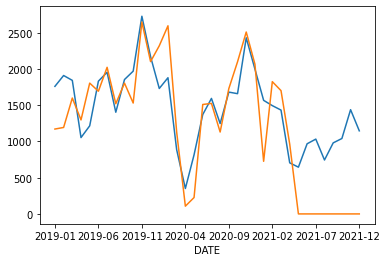

In [9]:
df.groupby(['DATE']).sum()['PREDICTED'].plot()
df.groupby(['DATE']).sum()['CANTIDAD'].plot()